In [3]:
# Goal: MAPS (matplotlib, bokeh) of embedded and clustered documents (t-SNE, UMAP) by topics (9, 70)
# To do: move t-SNE, UMAP to plotly; compare components (2/3D)

# Helper libraries
import pandas as pd
import numpy as np
import random
import spacy

# Dimensionality reduction (topic model, embedding)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import umap

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, Range1d
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

#import plotly as py

Loading BokehJS ...

In [2]:
# DATA Read documents (articles, projects) from csv; create text column 'combined' (title, abstract)
print("Loading documents")
df = pd.read_csv("data/ERI-combined-full-2009-2019.csv")
df['combined'] = df['title'].astype(str) + ' ' + df['abstract'].astype(str)
print(len(df))
df.head()

Loading documents
3770


,id,start_year,end_year,title,abstract,type,authors,identifier,combined
0,0a,2019,2019,"Proteomic, gene and metabolite characterizatio...",Cadmium sulfide quantum dots regulate nanomate...,article,"Majumdar, Sanghamitra; Pagano, Luca; Wohlschle...",10.1039/c9en00599d,"Proteomic, gene and metabolite characterizatio..."
1,1000a,2014,2014,Evaluation of Aquarius Level 2 Soil Moisture P...,Validation is important for any satellite-base...,article,"Li, Dongyang; Zhao, Tianjie; Shi, Jiancheng; B...",10.1109/igarss.2014.6946966,Evaluation of Aquarius Level 2 Soil Moisture P...
2,1001a,2014,2014,Fusion of Space-Based CO2 Products and its Com...,"Currently, ascertaining and quantifying the gl...",article,"Jing, Yingying; Shi, Jiancheng; Wang, Tianxing",10.1109/igarss.2014.6946946,Fusion of Space-Based CO2 Products and its Com...
3,1002a,2014,2014,Water Vapor Retrieval Over Cloud Cover Area on...,This study mainly discusses atmospheric water ...,article,"Ji, Dabin; Shi, Jiancheng",10.1109/jstars.2014.2298979,Water Vapor Retrieval Over Cloud Cover Area on...
4,1003a,2014,2014,Toward Accurate XCO2 Level 2 Measurements by C...,Carbon dioxide (CO2) is one of the most import...,article,"Jing, Yingying; Wang, Tianxing; Shi, Jiancheng",10.1109/eorsa.2014.6927857,Toward Accurate XCO2 Level 2 Measurements by C...


In [57]:
# NLP Remove stopwords, vectorize text with unigrams and bigrams, construct matrix of TFIDF features
# TO DO: check for duplicate documents (by id | title); reset index
# df = docs.drop_duplicates(subset='identifier', keep="first")
# df.reset_index()

# TO DO: lemmatize distinct terms
# nlp = spacy.load('en', disable=['parser', 'ner'])
# df['combined_lemma'] = df.combined.map(lambda x: [token.lemma_ for token in nlp(x) if token.lemma_ != '-PRON-' and token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV'}])
# df['combined_lemma'] = df.combined_lemma.map(lambda x: [t for t in x if len(t) > 1])
# print(df['combined_lemma'][0][:10], end='\n\n') #example of lemmatized text

np.random.seed(13) #set random seed for reproducbility
n_features = 1000 #optional - number of features ordered by term frequency to include in model
n_topics = 9 #number of topics - coarse thematic granularity; will match labels
#n_topics = 70 #number of topics- fine thematic granularity; no labels assigned
n_top_words = 10 #number of keywords returned per topic

custom_stop_words = []
with open( "mallet-2.0.8/stoplists/en-custom.txt", "r" ) as fin:  #load custom stop word list
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )

# TO DO: vectorize lemmatized text column instead of 'combined' text column
#vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 2)
#tfidf = tfidf_vectorizer.fit_transform(df.combined_lemma.map(lambda x: ' '.join(x)))
#tfidf = tfidf_vectorizer.fit_transform(df.combined.map(lambda x: ' '.join(x)))

tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['combined'])
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (tfidf.shape[0], tfidf.shape[1]) ) #terms by features

Created 3770 X 80152 TF-IDF-normalized document-term matrix


In [58]:
# TOPIC MODEL build embedding for topics, return topics and keywords
#nmf = NMF(n_components=n_topics, init="nndsvd", random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)
nmf = NMF(n_components=n_topics, init="nndsvd").fit(tfidf) # create the model

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
        
print("Topics found via NMF:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# apply the model and extract the two factor matrices (W, H)
#W = nmf.fit_transform( tfidf ) # W factor contains the document membership weights relative to each of the k topics
#W[0,:].round(2)

#H = nmf.components_ # H factor contains the term weights relative to each of the k topics
#term_index = terms.index('climate') # test and see topic(s) associated with term "climate"
#H[:,term_index].round(2)

Topics found via NMF:

Topic #0:
ocean carbon water co2 phytoplankton global surface organic color emissions


Topic #1:
ma rocks crustal metamorphism monazite crust zircon metamorphic deformation exhumation


Topic #2:
snow swe snow cover cover water snow water modis snowmelt model water equivalent


Topic #3:
soil soil moisture moisture vegetation microbial microwave surface soils band plant


Topic #4:
climate change climate change fire management land adaptation water impacts forest


Topic #5:
species diversity plant richness native biomass communities biodiversity effects ecosystem


Topic #6:
fault slip earthquake rupture seismic motion ground faults earthquakes ground motion


Topic #7:
mantle lavas isotopic crust 3he melt samoan geochemical 4he 3he 4he


Topic #8:
sediment ice erosion rates 10be river sea erosion rates glacial precipitation



In [59]:
# TOPIC MODEL transform tfidf-matrix into nmf-embedding; find document titles/authors most associated with each topic
nmf_embedding = nmf.transform(tfidf)
top_idx = np.argsort(nmf_embedding,axis=0)[-3:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(df.iloc[idx]['title'])  
        print(df.iloc[idx]['authors'])
    count += 1


Topic 0:
The Global Distribution and Dynamics of Chromophoric Dissolved Organic Matter
Nelson, Norman B.; Siegel, David A.
A Mechanistic Approach Towards the Remote Assessment of Carbon Export by Sinking Particles in the Open Ocean
David Siegel; Norm Nelson
Ocean Color Observations on CLIVAR: Inherent Optical Propoerties and Community Structure on Trans-Ocean Sections
Norm Nelson; Craig Carlson; David Siegel

Topic 1:
Structural and metamorphic evolution of the Karakoram and Pamir following India Kohistan Asia collision
Searle, M. P.; Hacker, B. R.
Thermochronology of extensional orogenic collapse in the deep crust of Zealandia
Schwartz, Joshua J.; Stowell, Harold H.; Klepeis, Keith A.; Tulloch, Andy J.; Kylander-Clark, Andrew R.C.; Hacker, Bradley R.; Coble, Matthew A.
Time Scales of Metamorphism, Deformation, and Crustal Melting in a Continental Arc, North Cascades USA
Gordon, Stacia M.; Bowring, Samuel A.; Whitney, Donna L.; Miller, Robert B.; McLean, Noah

Topic 2:
Error Analysis 

In [61]:
# TOPIC MODEL optional - assign arbitrary labels to topics to interpret embedding and clustering (9 topic model only)
topics = ['ocean (carbon biogeochemistry)',
          'rocks (solid earth)',
          'snow (mountain hydrology)',
          'soil (surface vegetation)',
          'climate (adaptation management)',
          'species (ecosystem diversity)',
          'fault (seismic motion)',
          'mantle (lavas geochemical)',
          'sediment (erosion precipitation)']

Documents to be embedded and visualized:
3770


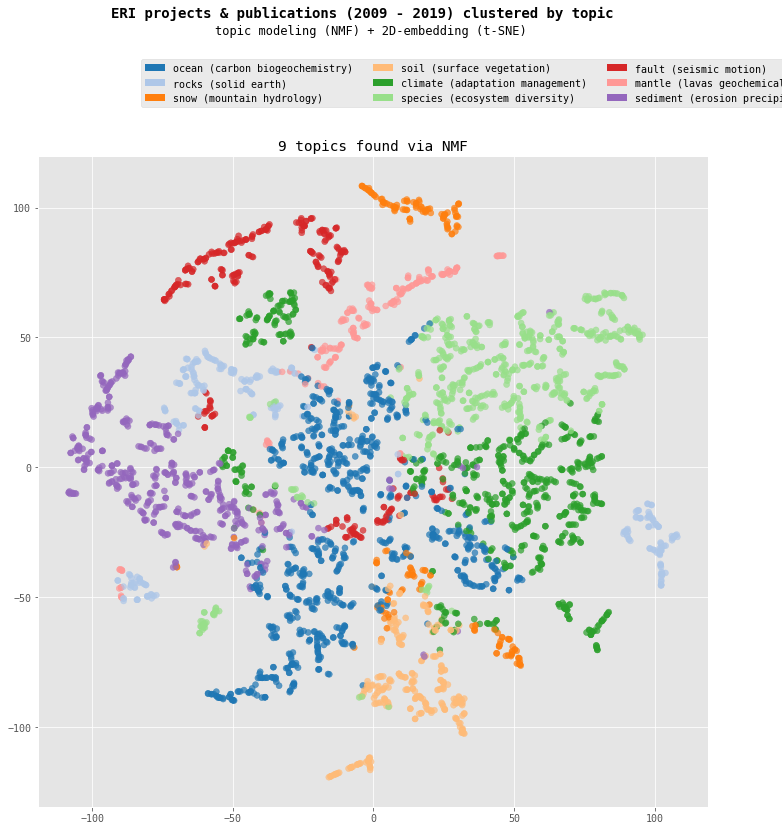

In [62]:
# VISUALIZE t-SNE, matplotlib (static - single view); 9 topic model
# PARAMETERS: refine perplexity (5-50), early_exaggeration (default: 12.0)
tsne = TSNE(perplexity=7, early_exaggeration=5, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
print("Documents to be embedded and visualized:")
print(len(tsne_embedding))

tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)
tsne_colors = [all_palettes['Category20'][20][i] for i in tsne_embedding.hue]

legend_list = []
for color in all_palettes['Category20'][20][:n_topics]:   
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

# TO DO: create legend with custom symbology; slice plots by start_year
# data = tsne_embedding[df['start_year']<=year]
# count = 0
# legend = []
# for year, idx in zip([2010,2013,2016,2019], range(4)):
#     data = tsne_embedding[df['start_year']<=year]
#     scatter = axs[idx].scatter(data=data,x='x',y='y',s=4,c='hue',cmap="tab10",alpha=0.7)
#     axs[idx].set_title('published/funded from 2009 through {}'.format(year),**{'fontsize':'10'})
#     axs[idx].axis('off')
# scatter = plt.scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="Set2")
# plt.axis('off')
# plt.show()
# colors = []
# for i in range(len(topics)):
#     idx = np.where(tsne_embedding['hue']==i)[0][0]
#     color = scatter.get_facecolors()[idx]
#     colors.append(color)
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
# colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ], #optional - hardcode colors in t-SNE plot
#  [ 0.22685121,  0.51898501,  0.66574396,  1. ],
#  [ 0.38731259,  0.57588621,  0.39148022,  1. ],
#  [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
#  [ 1.        ,  0.78937332,  0.11607843,  1. ],
#  [ 0.75226453,  0.52958094,  0.16938101,  1. ],
#  [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
#  [ 0.60000002,  0.60000002,  0.60000002,  1. ],
#  [ 1,  0.74211076,  0.0944053,  1. ]])
# legend_list = []
# for i in range(len(topics)):   
#     color = colors[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
#axs = axs.ravel()
#axs[idx].axis('off')

matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

fig,ax = plt.subplots(1,1, figsize=(12,13), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

ax.scatter(tsne_embedding.x, tsne_embedding.y, c=tsne_colors, alpha=0.7)
#ax.scatter(tsne_embedding.x, tsne_embedding.y, c='black', alpha=0.7)
#ax.scatter(centroids[:,0], centroids[:,1], c='black', s=100, alpha=0.7, marker='x')
ax.set_title('9 topics found via NMF');
fig.legend(legend_list, topics, loc=(0.18,0.87), ncol=3)
plt.subplots_adjust(top=0.82)
plt.suptitle("ERI projects & publications (2009 - 2019) clustered by topic", **{'fontsize':'14','weight':'bold'});
plt.figtext(.51,0.95, 'topic modeling (NMF) + 2D-embedding (t-SNE)', 
            **{'fontsize':'12','weight':'light'}, ha='center');
plt.show()
#plt.savefig('figures/NMF-t-SNE-9-topic.png')

Documents to be embedded and visualized:
3770


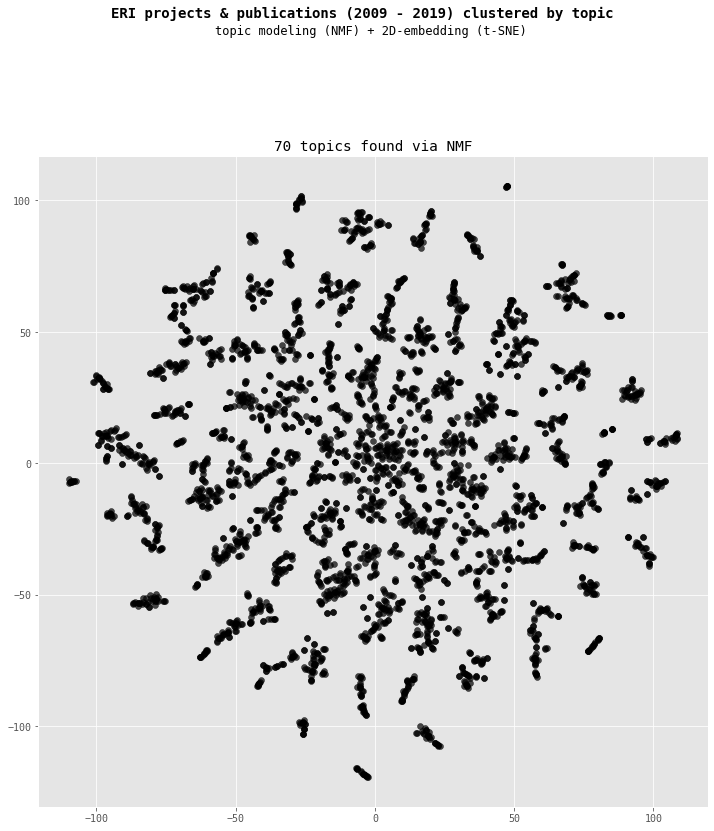

In [48]:
# VISUALIZE t-SNE, matplotlib (static - single view); 70 topic model
# PARAMETERS: refine perplexity (5-50), early_exaggeration (default: 12.0)
tsne = TSNE(perplexity=7, early_exaggeration=5, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
print("Documents to be embedded and visualized:")
print(len(tsne_embedding))
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

# tsne_colors = [all_palettes['Category20'][20][i] for i in tsne_embedding.hue]
# legend_list = []
# for color in all_palettes['Category20'][20][:n_topics]:   
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

# TO DO: create legend with custom symbology; slice plots by start_year
# data = tsne_embedding[df['start_year']<=year]
# count = 0
# legend = []
# for year, idx in zip([2010,2013,2016,2019], range(4)):
#     data = tsne_embedding[df['start_year']<=year]
#     scatter = axs[idx].scatter(data=data,x='x',y='y',s=4,c='hue',cmap="tab10",alpha=0.7)
#     axs[idx].set_title('published/funded from 2009 through {}'.format(year),**{'fontsize':'10'})
#     axs[idx].axis('off')
# scatter = plt.scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="Set2")
# plt.axis('off')
# plt.show()
# colors = []
# for i in range(len(topics)):
#     idx = np.where(tsne_embedding['hue']==i)[0][0]
#     color = scatter.get_facecolors()[idx]
#     colors.append(color)
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
# colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ], #optional - hardcode colors in t-SNE plot
#  [ 0.22685121,  0.51898501,  0.66574396,  1. ],
#  [ 0.38731259,  0.57588621,  0.39148022,  1. ],
#  [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
#  [ 1.        ,  0.78937332,  0.11607843,  1. ],
#  [ 0.75226453,  0.52958094,  0.16938101,  1. ],
#  [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
#  [ 0.60000002,  0.60000002,  0.60000002,  1. ],
#  [ 1,  0.74211076,  0.0944053,  1. ]])
# legend_list = []
# for i in range(len(topics)):   
#     color = colors[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
#axs = axs.ravel()
#axs[idx].axis('off')

matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

fig,ax = plt.subplots(1,1, figsize=(12,13), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

ax.scatter(tsne_embedding.x, tsne_embedding.y, c='black', alpha=0.7)
ax.set_title('70 topics found via NMF');
#fig.legend(legend_list, topics, loc=(0.18,0.87), ncol=3)
plt.subplots_adjust(top=0.82)
plt.suptitle("ERI projects & publications (2009 - 2019) clustered by topic", **{'fontsize':'14','weight':'bold'});
plt.figtext(.51,0.95, 'topic modeling (NMF) + 2D-embedding (t-SNE)', 
            **{'fontsize':'12','weight':'light'}, ha='center');
plt.show()
#plt.savefig('figures/NMF-t-SNE-70-topic.png')

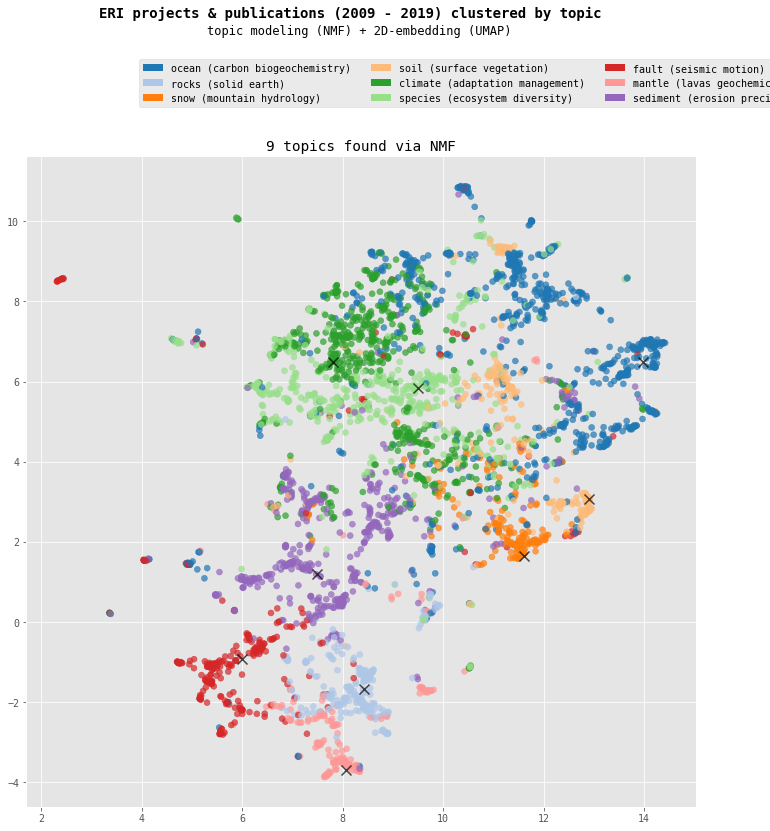

In [43]:
# VISUALIZE UMAP, matplotlib (static - single view); 9 topic model
# PARAMETERS: n_neighbors (default=15), metric (cosine, euclidean...), min_dist (default=0.1)
umap_embr = umap.UMAP(n_neighbors=10, metric='cosine', min_dist=0.1, random_state=13)
embedding = umap_embr.fit_transform(tfidf.todense())
embedding = pd.DataFrame(embedding, columns=['x','y'])

centroids = umap_embr.transform(nmf.components_)
embedding['hue'] = nmf_embedding.argmax(axis=1)
umap_colors = [all_palettes['Category20'][20][i] for i in embedding.hue]

matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

legend_list = []
for color in all_palettes['Category20'][20][:n_topics]:   
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
    
fig,ax = plt.subplots(figsize=(12,13))
# fig, axs = plt.subplots(2,2, figsize=(10, 15), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .1, wspace=0)
#ax.scatter(embedding.x, embedding.y, c=my_colors, alpha=0.7)
# axs = axs.ravel()
# count = 0
# legend = []
# for year, idx in zip([2010,2013,2016,2019], range(4)):
#     data = embedding[df['start_year']<=year]
#     scatter = axs[idx].scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="tab10")
#     axs[idx].set_title('published/funded from 2009 through {}'.format(year),**{'fontsize':'10'})
#     axs[idx].axis('off')

ax.scatter(embedding.x, embedding.y, c=umap_colors, alpha=0.7)
ax.scatter(centroids[:,0], centroids[:,1], c='black', s=100, alpha=0.7, marker='x')
ax.set_title('9 topics found via NMF');
fig.legend(legend_list, topics, loc=(0.18,0.87), ncol=3)
plt.subplots_adjust(top=0.82)
plt.suptitle("ERI projects & publications (2009 - 2019) clustered by topic", **{'fontsize':'14','weight':'bold'});
plt.figtext(.51,0.95, 'topic modeling (NMF) + 2D-embedding (UMAP)', 
            **{'fontsize':'12','weight':'light'}, ha='center');
plt.show()
#plt.savefig('figures/NMF-UMAP-9-topic.png')

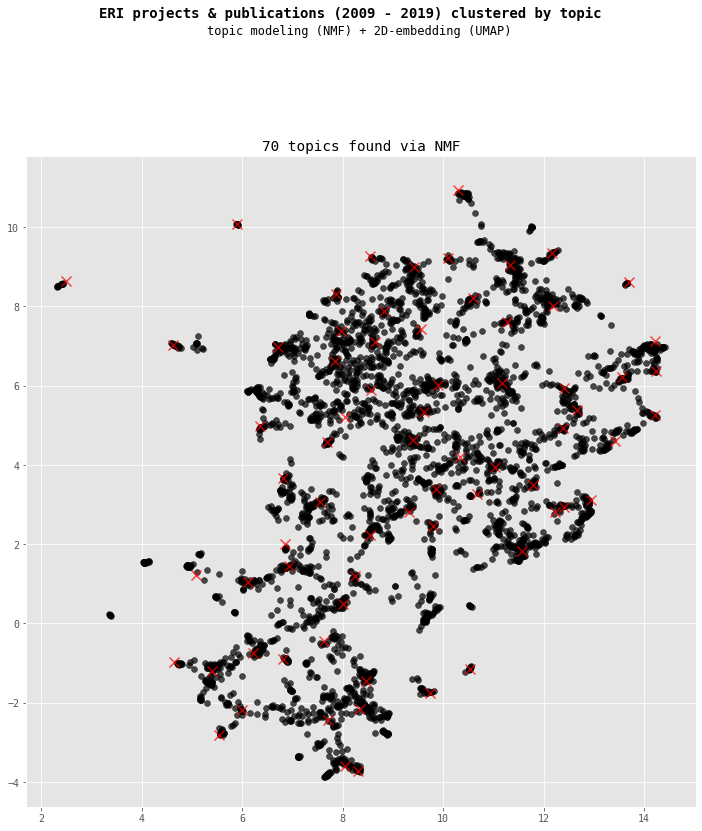

In [53]:
# VISUALIZE UMAP, matplotlib (static - single view); 70 topic model
# PARAMETERS: n_neighbors (default=15), metric (cosine, euclidean...), min_dist (default=0.1)
umap_embr = umap.UMAP(n_neighbors=10, metric='cosine', min_dist=0.1, random_state=13)
embedding = umap_embr.fit_transform(tfidf.todense())
embedding = pd.DataFrame(embedding, columns=['x','y'])

centroids = umap_embr.transform(nmf.components_)
embedding['hue'] = nmf_embedding.argmax(axis=1)
#umap_colors = [all_palettes['Category20'][20][i] for i in embedding.hue]

matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')

# legend_list = []
# for color in all_palettes['Category20'][20][:n_topics]:   
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
    
fig,ax = plt.subplots(figsize=(12,13))
# fig, axs = plt.subplots(2,2, figsize=(10, 15), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .1, wspace=0)
#ax.scatter(embedding.x, embedding.y, c=my_colors, alpha=0.7)
# axs = axs.ravel()
# count = 0
# legend = []
# for year, idx in zip([2010,2013,2016,2019], range(4)):
#     data = embedding[df['start_year']<=year]
#     scatter = axs[idx].scatter(data=data,x='x',y='y',s=4,c=data['hue'],cmap="tab10")
#     axs[idx].set_title('published/funded from 2009 through {}'.format(year),**{'fontsize':'10'})
#     axs[idx].axis('off')

ax.scatter(embedding.x, embedding.y, c='black', alpha=0.7)
ax.scatter(centroids[:,0], centroids[:,1], c='red', s=100, alpha=0.7, marker='x')
ax.set_title('70 topics found via NMF');
#fig.legend(legend_list, topics, loc=(0.18,0.87), ncol=3)
plt.subplots_adjust(top=0.82)
plt.suptitle("ERI projects & publications (2009 - 2019) clustered by topic", **{'fontsize':'14','weight':'bold'});
plt.figtext(.51,0.95, 'topic modeling (NMF) + 2D-embedding (UMAP)', 
            **{'fontsize':'12','weight':'light'}, ha='center');
plt.show()
#plt.savefig('figures/NMF-UMAP-70-topic.png')

In [63]:
# VISUALIZE t-SNE, Bokeh (interactive); 9 topic model
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = tsne_colors,
            topic = [topics[i] for i in tsne_embedding.hue],
            title = df.title,
            author = df.authors,
            year = df.start_year,
            types = df.type,
            alpha = [0.7] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
        )
    )
hover_emb = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Topic:</span>
            <span style="font-size: 12px">@topic</span>
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Authors:</span>
            <span style="font-size: 12px">@author</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
            <span style="font-size: 12px; font-weight: bold;">Type:</span>
            <span style="font-size: 12px">@types</span>
        </div>
    </div>
    """)
tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset']
plot_emb = figure(plot_width=600, plot_height=600, tools=tools_emb, title='ERI projects & publications clustered by topic (t-SNE)')
# plot_emb.circle('x', 'y', size='size', fill_color='black', 
#                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")
plot_emb.circle('x', 'y', size='size', fill_color='colors', alpha='alpha', 
                line_alpha=0, line_width=0.01, source=source, name='df', legend='topic')

for i in range(n_topics):
    #plot_emb.cross(x=centroids[i,0], y=centroids[i,1], size=15, color='black', line_width=2, angle=0.79)
    plot_emb.legend.location = "bottom_left"
    plot_emb.legend.label_text_font_size= "8pt"
    plot_emb.legend.spacing = -5

plot_emb.x_range = Range1d(-150, 150)
plot_emb.y_range = Range1d(-150, 120)

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    topic = data['topic']
    alpha = data['alpha']
    author = data['authors']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """
                   )

slider = Slider(start=df.start_year.min()-1, end=df.start_year.max(), value=2019, step=1, title="Before year")
slider.js_on_change('value', callback)

# output_file('outputs/NMF/NMF-t-SNE-9-topic.html', 
#             title='ERI projects & publications clustered by topic (t-SNE)')

layout_tsne = column(slider, plot_emb)
show(layout_tsne)

In [56]:
# VISUALIZE t-SNE, Bokeh (interactive); 70 topic model
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            #colors = tsne_colors,
            #topic = [topics[i] for i in tsne_embedding.hue],
            title = df.title,
            author = df.authors,
            year = df.start_year,
            types = df.type,
            alpha = [0.7] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
        )
    )
hover_emb = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Authors:</span>
            <span style="font-size: 12px">@author</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
            <span style="font-size: 12px; font-weight: bold;">Type:</span>
            <span style="font-size: 12px">@types</span>
        </div>
    </div>
    """)
tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset']
plot_emb = figure(plot_width=600, plot_height=600, tools=tools_emb, title='ERI projects & publications clustered by topic (t-SNE)')
plot_emb.circle('x', 'y', size='size', fill_color='black', alpha='alpha', 
                line_alpha=0, line_width=0.01, source=source, name='df')

# for i in range(n_topics):
#     plot_emb.cross(x=centroids[i,0], y=centroids[i,1], size=15, color='black', line_width=2, angle=0.79)
#     plot_emb.legend.location = "bottom_left"
#     plot_emb.legend.label_text_font_size= "8pt"
#     plot_emb.legend.spacing = -5

plot_emb.x_range = Range1d(-150, 150)
plot_emb.y_range = Range1d(-150, 120)

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    alpha = data['alpha']
    author = data['authors']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """
                   )

slider = Slider(start=df.start_year.min()-1, end=df.start_year.max(), value=2019, step=1, title="Before year")
slider.js_on_change('value', callback)

# output_file('outputs/NMF/NMF-t-SNE-70-topic.html', 
#             title='ERI projects & publications clustered by topic (t-SNE)')

layout_tsne = column(slider, plot_emb)
show(layout_tsne)

In [41]:
# VISUALIZE UMAP, Bokeh (interactive)
centroids = umap_embr.transform(nmf.components_)
embedding['hue'] = nmf_embedding.argmax(axis=1)
umap_colors = [all_palettes['Category20'][20][i] for i in embedding.hue]
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = umap_colors,
            topic = [topics[i] for i in embedding.hue],
            title = df.title,
            author = df.authors,
            year = df.start_year,
            types = df.type,
            alpha = [0.7] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_emb = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Topic:</span>
            <span style="font-size: 12px">@topic</span>
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Authors:</span>
            <span style="font-size: 12px">@author</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
            <span style="font-size: 12px; font-weight: bold;">Type:</span>
            <span style="font-size: 12px">@types</span>
        </div>
    </div>
    """)
tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset']
plot_emb = figure(plot_width=700, plot_height=700, tools=tools_emb, title='ERI projects & publications clustered by topic (UMAP)')
plot_emb.circle('x', 'y', size='size', fill_color='colors',
                alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df", legend='topic')

for i in range(n_topics):
    plot_emb.cross(x=centroids[i,0], y=centroids[i,1], size=15, color='black', line_width=2, angle=0.79)
plot_emb.legend.location = "bottom_left"
plot_emb.legend.label_text_font_size= "8pt"
plot_emb.legend.spacing = -5

plot_emb.x_range = Range1d(0, 16)
plot_emb.y_range = Range1d(-5, 12)

callback = CustomJS(args=dict(source=source), code=
                    """
                    var data = source.data;
                    var f = cb_obj.value
                    x = data['x']
                    y = data['y']
                    colors = data['colors']
                    alpha = data['alpha']
                    title = data['title']
                    year = data['year']
                    size = data['size']
                    for (i = 0; i < x.length; i++) {
                        if (year[i] <= f) {
                            alpha[i] = 0.9
                            size[i] = 7
                    } else {
                        alpha[i] = 0.05
                        size[i] = 4
                        }
                    }
                    source.change.emit();
                    """)

slider = Slider(start=df.start_year.min()-1, end=df.start_year.max(), value=2019, step=1, title="Before year")
slider.js_on_change('value', callback)

# output_file('outputs/NMF/NMF-UMAP-9-topic.html', 
#             title='ERI projects & publications clustered by topic (UMAP)')

layout_umap = column(slider, plot_emb)
show(layout_umap)